# King County House Price Prediction Model

## Import Necessary Functions and Packages


In [69]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
import pylab
import pickle
import category_encoders as ce
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Feature Engineering and Data Transformation

In [70]:
# Visualization Functions
def num_plots(df):
    num_cols = list(c.select_dtypes(exclude=['object']).columns)
    for col in b[cat_cols]:
        print(col)

def cat_plots(df):
    cat_cols = list(c.select_dtypes(include=['object']).columns)
    for col in b[cat_cols]:
        print(col)

def corr_plots(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(20, 15))
    sns.heatmap(corr_matrix, annot=True, cmap='viridis')
    plt.title('Correlation Matrix of Features')
    plt.show()

def corr_table(df):
    corr = df.corr()
    display(corr)

In [71]:
# Data Importing and Wrangling Functions
def file_reader(path):
    '''This function extracts the contents of a csv file, loads it into a pandas dataframe and then returns the top 10 columns of the dataframe. 
    Input : CSV filepath
    Output: DataFrame'''
    
    # Import Dataframe from Filepath
    data = pd.read_csv(path, na_values=["nan","n.a","not available","?","NaN"])
    
    # Return Imported Pandas DataFrame
    return data

def feature_wrangler(df):
    '''This function examines the columns of the House Prices DataFrame, performs some feature enginnering on the columns and and then returns the cleaned dataframe, returning the top 10 columns of the cleaned dataframe. 
    Input : Uncleaned DataFrame
    Output: Cleaned DataFrame'''

    # Set the Index to the id Column and Drop the id Column
    df.index = df['id']
    df = df.drop(columns = ['id', 'date', 'lat', 'long'], axis = 1)

    # Replace Missing Values in Dataset According to Datatypes (Mode for Categories. Mean for Continuous)
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].nunique() > 10:
                df[col] = df[col].fillna(df[col].mean())
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Set Datatypes For Categorical Features
    df['condition'] = df['condition'].astype(object)
    df['grade'] = df['grade'].astype(object)
    df['zipcode'] = df['zipcode'].astype(object)
    df['waterfront'] = df['waterfront'].astype(object)

    # Return Cleaned Dataset
    return df

def outlier_remover(df):
    '''
    This function filters out all values above and below three standard deviations from the mean
    '''
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            if col not in ['lat', 'long']:
                mean = df[col].mean()
                std = df[col].std()
                df = df[(df[col] > df[col].mean() - 3 * df[col].std()) & (df[col] < df[col].mean() + 3 * df[col].std())]
                
    # Return Dataset With Outliers Removed       
    return df

def cat_encoder(df):
    # Instantiate Target Encoder
    te=ce.TargetEncoder()

    # Extract the Categorical Columns
    cat_cols = list(df.select_dtypes(include=['object']).columns)
    
    # Target-Encode the Categorical Features 
    for col in cat_cols:
        df[col]=te.fit_transform(df[col],df.price)

    # Return Dataset With Categorical Features Transformed 
    return df

def vif_screener(df):
    # Branch Out Dataframe into 2 Dataframes to Examine the VIF Before and After Highly Correlated Columns are Dropped
    d_before = df
    d_after = df

    # VIF Before Dropping Columns
    before_dropping = sm.tools.add_constant(d_before)
    series_before = pd.Series([variance_inflation_factor(before_dropping.values, i) for i in range(before_dropping.shape[1])], index = before_dropping.columns)
    
    # Display the series
    print('VIF BEFORE DROPPING HIGHLY CORRELATED COLUMNS COLUMNS')
    print('-'*55)
    display(series_before)
    
    # Define Columns to Drop based on VIF Threshold
    high_vif = series_before[series_before > 5]
    high_vif = high_vif.index.to_list()
    high_vif.remove('const')
    high_vif

    # VIF After Dropping Columns
    d_after = d_after.drop(columns = high_vif)
    after_dropping = sm.tools.add_constant(d_after)
    series_after = pd.Series([variance_inflation_factor(after_dropping.values, i) for i in range(after_dropping.shape[1])], index = after_dropping.columns)
    
    # Display the series
    print('VIF AFTER DROPPING HIGHLY CORRELATED COLUMNS COLUMNS')
    print('-'*55)
    display(series_after)

    # Collect Columns into New List and Create New Dataframe 
    final_columns = series_after.index.to_list()
    final_columns.remove('const')
    final_columns 
    
    df = df[final_columns]
    
    return df

In [ ]:
a = file_reader('https://raw.githubusercontent.com/Amberlynnyandow/dsc-1-final-project-online-ds-ft-021119/master/kc_house_data.csv')
b = feature_wrangler(a)
c = outlier_remover(b)
d = cat_encoder(c)
e = vif_screener(d)

## Data Split and Model Building

In [73]:
# Get the Target and Feature variables
X = e.drop('price', axis = 1)
y = e[['price']]

# Split the dataset to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 420)

# Create an instance for our model
regression_model = LinearRegression()

# Fit the model
regression_model.fit(X_train, y_train)

# Get the Price Prediction on the Test Data
y_predict = regression_model.predict(X_test)

# Show the first 5 Predictions
y_predict[:5]

array([[ 404030.07864595],
       [1023283.38799492],
       [ 338627.46022273],
       [ 422954.17541351],
       [ 331963.05875397]])

## Model Performance Check

In [74]:
# Model Performance Metrics
# Calculate the mean squared error
model_mse = mean_squared_error(y_test, y_predict)

# Calculate the mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

# Calculate the root mean squared error
model_rmse = math.sqrt(model_mse)

# Display the output
print(f"MSE : {model_mse:.3}")
print(f"MAE : {model_mae:.3}")
print(f"RMSE : {model_rmse:.3}")

MSE : 1.08e+10
MAE : 7.35e+04
RMSE : 1.04e+05


## Model Results and Hypothesis Testing

In [75]:
# Create the input
X_model = sm.add_constant(X)

# Create an OLS model
model = sm.OLS(y, X_model)

# Fit the model
est = model.fit()

# SHow Model Summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     4802.
Date:                Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:14:48   Log-Likelihood:            -2.4190e+05
No. Observations:               18603   AIC:                         4.838e+05
Df Residuals:                   18589   BIC:                         4.839e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.252e+06   4.46e+05      2.807

## Model Diagnostics Check

### Autocorrelation Check
The autocorrelation function is used to check for the presence of autocorrelation. The ACF plot clearly shows that the model does not suffer from 
autocorrelation in its residuals as every lag beyond the first lag is very close to zero.

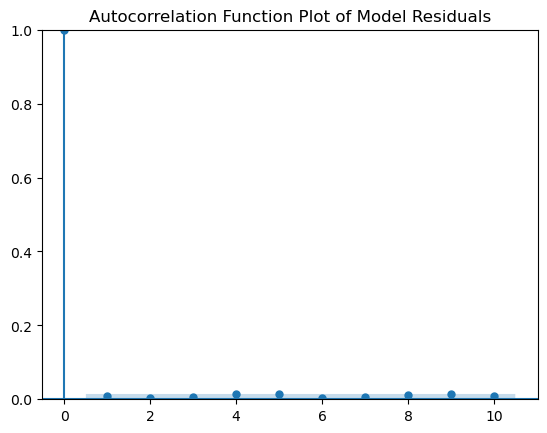

In [76]:
# Plot Model Residual Autocorrelation Function
fig = tsaplots.plot_acf(est.resid, lags=10)
plt.ylim([0.00,1.00])
plt.title('Autocorrelation Function Plot of Model Residuals')
plt.show();

### Heteroskedasticity check
The Lagrange multiplier statistic for the test is 6.0039 and the corresponding p-value is 0.1114. Because this p-value is not less than 0.05, we fail to reject the null hypothesis. Consequently, We do not have sufficient evidence to say that heteroscedasticity is present in the regression model.

In [77]:
# Perform Bresuch-Pagan test
labels = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f (p-value)']
test = diag.het_breuschpagan(est.resid, est.model.exog)

lzip(labels, test)

[('Lagrange multiplier statistic', 6.003951995818433),
 ('p-value', 0.11141811013399583),
 ('f-value', 3.004944880309618),
 ('f p-value', 0.11663863538255281)]

[('Lagrange multiplier statistic', 6.003951995818433),
 ('p-value', 0.11141811013399583),
 ('f-value', 3.004944880309618),
 ('f p-value', 0.11663863538255281)]

### Normality Check
The model QQ-Plot follows the diagonal line in the plot and mean of residuals are very close to zero, indicating that the
model errors are normally distributed. 

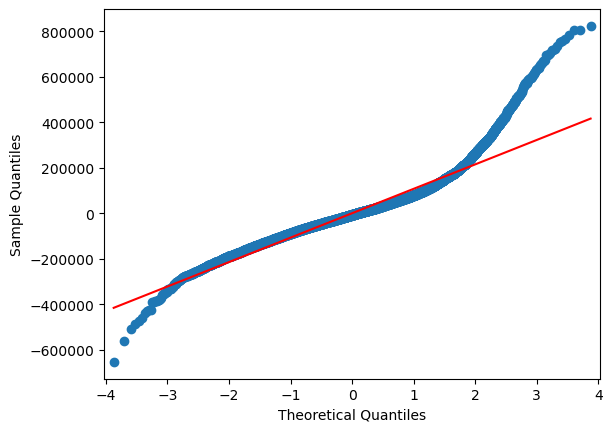

-7.906808727800094e-06

In [78]:
# Check for the normality
sm.qqplot(est.resid, line = 's')
pylab.show()

# Check that the mean of the residual = 0
mean_residuals = sum(est.resid) / len(est.resid)
mean_residuals

## Save Price Prediction Model

In [ ]:
# Pickle the Model
with open('king-county-model.pkl', 'wb') as f:
    pickle.dump(regression_model, f)
    
# Load it back in
with open('king-county-model.pkl', 'rb') as pickle_file:
    regression_model_2 = pickle.load(pickle_file)